In [1]:
import os
from glob import glob
#import glob
import random
import time

import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid import ImageGrid
from cv2_plt_imshow import cv2_plt_imshow, plt_format


plt.style.use("dark_background")

<ipython-input-1-d47928b00ee7>:12: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import ImageGrid


In [2]:
DATA_PATH = "/home/sanyukta/projects/brain/lgg-mri-segmentation/kaggle_3m/"

#img size
IMG_SIZE = 512

In [3]:
def plot_rgb_hist(image):
  
  '''
  This method will plot the histogram of the 
  RGB values of an image.
  -----------------------------------
  Arguments
  image - the image for which to plot the histogram
  -----------------------------------

  '''
  #extract the red channel
  im= image[:, :, 0]
  plt.hist(im.ravel(), bins = 256, \
           color = 'Red', alpha = 0.5)
  
  #extract the green color
  im= image[:, :, 1]
  plt.hist(im.ravel(), bins = 256, \
           color = 'Green', alpha = 0.5)
  
  #extract the blue color
  im= image[:, :, 2]
  plt.hist(im.ravel(), bins = 256, \
           color = 'Blue', alpha = 0.5)
  plt.show()

In [4]:
train_files = []
mask_files = glob(DATA_PATH +'*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

In [5]:
df = pd.DataFrame()
df['train'] = train_files
df['mask'] = mask_files
df.head()

,train,mask
0,/home/sanyukta/projects/brain/lgg-mri-segmenta...,/home/sanyukta/projects/brain/lgg-mri-segmenta...
1,/home/sanyukta/projects/brain/lgg-mri-segmenta...,/home/sanyukta/projects/brain/lgg-mri-segmenta...
2,/home/sanyukta/projects/brain/lgg-mri-segmenta...,/home/sanyukta/projects/brain/lgg-mri-segmenta...
3,/home/sanyukta/projects/brain/lgg-mri-segmenta...,/home/sanyukta/projects/brain/lgg-mri-segmenta...
4,/home/sanyukta/projects/brain/lgg-mri-segmenta...,/home/sanyukta/projects/brain/lgg-mri-segmenta...


In [6]:
len(df)

3929

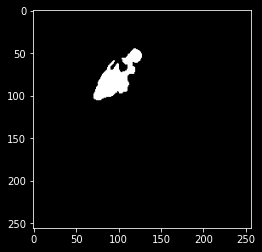

In [7]:
i = cv2.imread(df['mask'].iloc[1])
plt.imshow(i)

In [8]:
%%time
df['diag'] = 3
for i in range(len(df)):
  img = df['mask'].iloc[i]
  value = np.max(cv2.imread(img))
  if value > 0: 
    df['diag'].iloc[i] = 1
  else: 
    df['diag'].iloc[i] = 0


/home/sanyukta/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


CPU times: user 2.56 s, sys: 55.6 ms, total: 2.62 s
Wall time: 2.62 s


<AxesSubplot:>

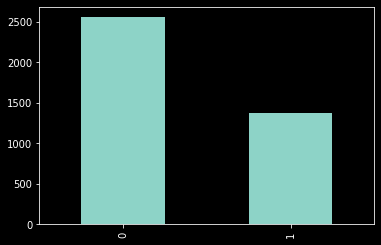

In [9]:
df['diag'].value_counts().plot(kind='bar')

In [10]:
df['diag'].value_counts()

0    2556
1    1373
Name: diag, dtype: int64

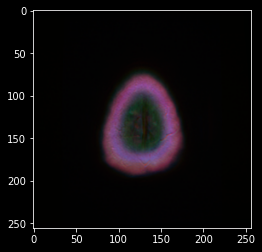

In [11]:
img = cv2.imread(df['train'].iloc[0])
plt.imshow(img)

Let's visualize the MRI segment 

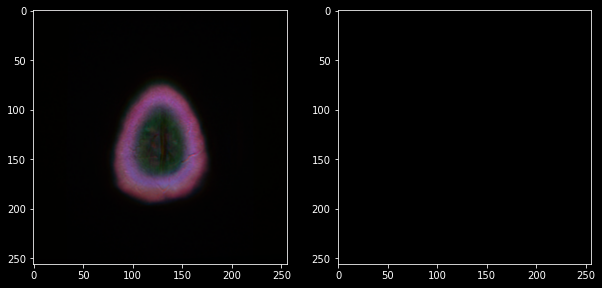

In [12]:
fig=plt.figure(figsize=(10,10))

fig.add_subplot(1,2,1)
img = cv2.imread(df['train'].iloc[0])
plt.imshow(img)
fig.add_subplot(1,2,2)
msk = cv2.imread(df['mask'].iloc[0])
plt.imshow(msk)

Visulaize tumor with the mask

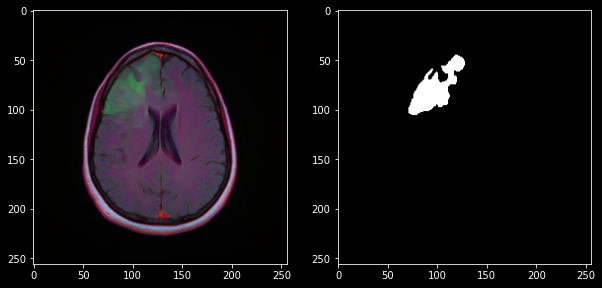

In [13]:
fig=plt.figure(figsize=(10,10))

fig.add_subplot(1,2,1)
img = cv2.imread(df['train'].iloc[1])
plt.imshow(img)
fig.add_subplot(1,2,2)
msk = cv2.imread(df['mask'].iloc[1])
plt.imshow(msk)

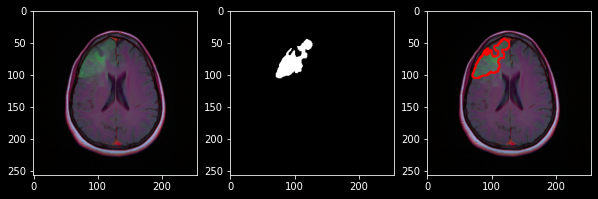

In [14]:
fig=plt.figure(figsize=(10,10))

#plotting the image
fig.add_subplot(1,3,1)
img = cv2.imread(df['train'].iloc[1])
plt.imshow(img)

#plotting the mask
fig.add_subplot(1,3,2)
msk = cv2.imread(df['mask'].iloc[1])
plt.imshow(msk)

#plotting the mask overlayed on the image
fig.add_subplot(1,3,3)
#identify the edges using the CannyEdgeDetector
edged = cv2.Canny(msk, 10, 250)
#find the contours on the the image(edge detected)
(cnts, _) = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#draw the contours
for cnt in cnts:
    cv2.drawContours(img,[cnt],0,(255,0,0),2)
plt.imshow(img)

Let's check weather all the image have its mask

In [15]:
len(df['train']) == len(df['mask'])

True

Looks like all the images have its masks.

Now we'll crop the image and the mask so as to remove any noise.

Before cropping any image we'll first need to enhance the contrast as some of the images are suffering from poor contrast.

For example take a look at the following image.

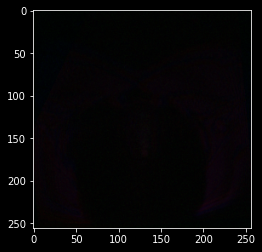

In [16]:
img = cv2.imread(df['train'].iloc[3740])
plt.imshow(img)

In [17]:
print (df['train'])

0       /home/sanyukta/projects/brain/lgg-mri-segmenta...
1       /home/sanyukta/projects/brain/lgg-mri-segmenta...
2       /home/sanyukta/projects/brain/lgg-mri-segmenta...
3       /home/sanyukta/projects/brain/lgg-mri-segmenta...
4       /home/sanyukta/projects/brain/lgg-mri-segmenta...
                              ...                        
3924    /home/sanyukta/projects/brain/lgg-mri-segmenta...
3925    /home/sanyukta/projects/brain/lgg-mri-segmenta...
3926    /home/sanyukta/projects/brain/lgg-mri-segmenta...
3927    /home/sanyukta/projects/brain/lgg-mri-segmenta...
3928    /home/sanyukta/projects/brain/lgg-mri-segmenta...
Name: train, Length: 3929, dtype: object


In [18]:
print (df['train'].iloc[3740], 0)

/home/sanyukta/projects/brain/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_47.tif 0


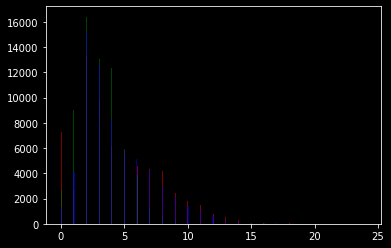

In [19]:
plot_rgb_hist(img)

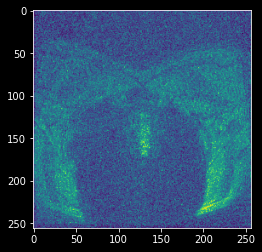

In [20]:

gray = cv2.imread(df['train'].iloc[3740], 0)
plt.imshow(gray)

CLAHE (Contrast Limited Adaptive Histogram Equalization)

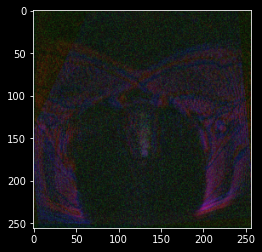

In [21]:
#set the clip value and the gridsize changing these values will give different output
clahe = cv2.createCLAHE(clipLimit=6, \
                    tileGridSize=(16,16))

#split the three channels
b,g,r = cv2.split(img)

#apply CLAHE on the three channels separately
b = clahe.apply(b)
g = clahe.apply(g)
r = clahe.apply(r)

#merge the three channels
bgr = cv2.merge((b,g,r))

# Window name in which image is displayed 
window_name = 'image'

#convert to RGB and plot
cl = cv2.cvtColor(bgr,cv2.COLOR_BGR2RGB);
plt.imshow(cl)


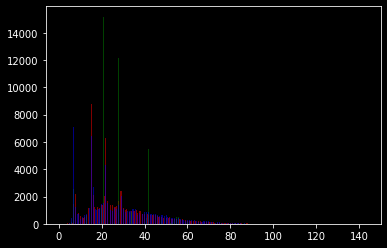

In [22]:
plot_rgb_hist(cl)

Original Image




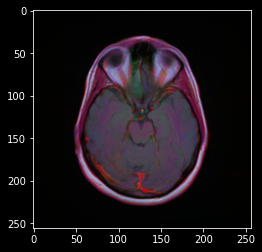

In [23]:
#load an image from the dataset
img = cv2.imread(df['train'].iloc[15])
print('Original Image')
plt.imshow(img)
print('\n')


CLAHE Enhanced




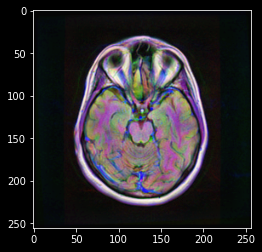

In [24]:

#set the clip value and the gridsize changing these values will give different output
clahe = cv2.createCLAHE(clipLimit=4, \
                    tileGridSize=(16,16))

#split the three channels
b,g,r = cv2.split(img)

#apply CLAHE on the three channels separately
b = clahe.apply(b)
g = clahe.apply(g)
r = clahe.apply(r)

#merge the three channels
equ = cv2.merge((b,g,r))

#convert to RGB and plot
rgb = cv2.cvtColor(equ,cv2.COLOR_BGR2RGB);
imgc = rgb.copy()
print('CLAHE Enhanced')
plt.imsave('clahe1.jpg', rgb) 
plt.imshow(rgb)
print('\n')

Edged Detected




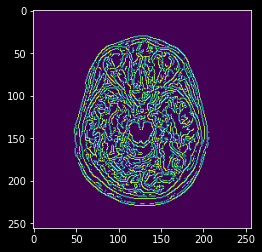

In [25]:
#Now we can now crop the image.
#to crop the image we'll first find the edges in the image.
edged = cv2.Canny(rgb, 10, 250)
print('Edged Detected')
plt.imsave('edge.jpg', edged) 
plt.imshow(edged)


print('\n')

Dilated Image




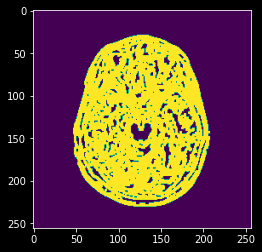

In [26]:
#Once we have the edges now we'll perform dilate operation to remove any small regions of noises
dilate = cv2.dilate(edged, None, iterations=1)
print('Dilated Image')
plt.imsave('dali.jpg', dilate) 
plt.imshow(dilate)
print('\n')

Contour




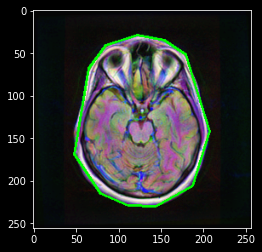

In [27]:
#Now we can find the contours in the image
(cnts, thres) = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for c in cnts:
  peri = cv2.arcLength(c, True)
  eps = 0.01 * peri
  approx = cv2.approxPolyDP(c, eps, True)
  cv2.drawContours(imgc, [approx], -1, (0, 255, 0), 2)
print('Contour')
plt.imsave('con.jpg', imgc) 
plt.imshow(imgc)
print('\n')

Cropped Image




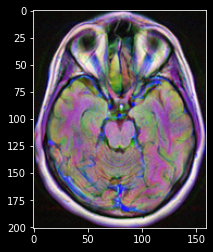

In [28]:
#Now we'll get the extreme points in the contours and crop the image
#https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/
c = max(cnts, key=cv2.contourArea)

extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])
new_image = rgb[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
print('Cropped Image')
plt.imsave('crop.jpg', new_image) 
plt.imshow(new_image)
print('\n')

In [29]:
import cv2 
#from google.colab.patches import cv2_imshow
from tqdm import tqdm
def crop_img():
#reading the image  
  z=[]
  for i in tqdm(range(len(df))):
    image = cv2.imread(df['train'].iloc[i])
    #gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask = cv2.imread(df['mask'].iloc[i])
    #imgc = image.copy()
    clahe = cv2.createCLAHE(clipLimit=4, \
                        tileGridSize=(16,16))
    b,g,r = cv2.split(image)

    #apply CLAHE on the three channels separately
    b = clahe.apply(b)
    g = clahe.apply(g)
    r = clahe.apply(r)

    #merge the three channels
    bgr = cv2.merge((b,g,r))

    #convert to RGB
    cl = cv2.cvtColor(bgr,cv2.COLOR_BGR2RGB)
    #edged = clahe.apply(gray_image) 
    imgc = cl.copy() 
    edged = cv2.Canny(cl, 10, 250)
    
    #cv2.waitKey(0) 

    #edged = cv2.erode(edged, None, iterations=1)
    edged = cv2.dilate(edged, None, iterations=2)
    
    #applying closing function
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
    closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
    
    #finding_contours  
    (cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) 
    
    if len(cnts) == 0:    
      cv2.imwrite('/content/train/'+df['train'].iloc[i][-28:], imgc)
      cv2.imwrite('/content/mask/'+df['mask'].iloc[i][-33:], mask)
    else:
      c = max(cnts, key=cv2.contourArea)
      extLeft = tuple(c[c[:, :, 0].argmin()][0])
      extRight = tuple(c[c[:, :, 0].argmax()][0])
      extTop = tuple(c[c[:, :, 1].argmin()][0])
      extBot = tuple(c[c[:, :, 1].argmax()][0])
      new_image = imgc[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
      mask = mask[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

      cv2.imwrite('/content/train/'+df['train'].iloc[i][-28:], new_image)
      cv2.imwrite('/content/mask/'+df['mask'].iloc[i][-33:], mask)

In [30]:
crop_img()

100%|██████████| 3929/3929 [00:12<00:00, 312.59it/s]


# Splitting the dataset for training, validation and testing

In [33]:
data_map = []
for sub_dir_path in glob.glob("/home/sanyukta/projects/brain/lgg-mri-segmentation/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

AttributeError: 'function' object has no attribute 'glob'

In [32]:
# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))

NameError: name 'df_imgs' is not defined

In [ ]:
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

In [ ]:
# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

In [ ]:
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0
    
brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df

In [ ]:
brain_df_train = brain_df.drop(columns=['patient_id'])
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

In [ ]:
from sklearn.model_selection import train_test_split

train, test=train_test_split(brain_df_train, test_size=0.1)
train, val=train_test_split(df_train, test_size=0.2)

print(train.values.shape)
print(val.values.shape)
print(test.values.shape)


In [ ]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255., validation_split=0.1)

train_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='training',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
valid_generator = datagen.flow_from_dataframe(train,
                                              directory='./',
                                              x_col='image_path',
                                              y_col='mask',
                                              subset='validation',
                                              class_mode='categorical',
                                              batch_size=16,
                                              shuffle=True,
                                              target_size=(256,256)
                                             )
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_dataframe(test,
                                                  directory='./',
                                                  x_col='image_path',
                                                  y_col='mask',
                                                  class_mode='categorical',
                                                  batch_size=16,
                                                  shuffle=False,
                                                  target_size=(256,256)
                                                 )

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
clf_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256,256,3)))
clf_model.summary()

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import cv2
import skimage

from skimage import io

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

import random
import glob
from sklearn.preprocessing import StandardScaler, normalize
from IPython.display import display

In [ ]:
# before this i tried with trainable layer but the accuracy was less as compared
for layer in clf_model.layers:
    layers.trainable = False

In [ ]:
head = clf_model.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='Flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(2, activation='softmax')(head)

model = Model(clf_model.input, head)
model.compile(loss = 'categorical_crossentropy', 
              optimizer='adam', 
              metrics= ["accuracy"]
             )
model.summary()

In [ ]:
head

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', 
                              mode='min', 
                              verbose=1, 
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-resnet-weights.hdf5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )
callbacks = [checkpointer, earlystopping, reduce_lr]

In [ ]:
h = model.fit(train_generator, 
              steps_per_epoch= train_generator.n // train_generator.batch_size, 
              epochs = 25, 
              validation_data= valid_generator, 
              validation_steps= valid_generator.n // valid_generator.batch_size, 
              callbacks=[checkpointer, earlystopping])